# Processing and Plotting SeaBASS (.sb) Files

This notebook contains a workflow for reading multiple SeaBASS (`.sb`) files from a folder, combining them, subsetting the data by date and station, and then plotting specific parameters.

We will use:
* `SB_support.py` (the provided module) to read the files.
* `pandas` to aggregate and filter the data.
* `matplotlib` to plot the results.

# Workflow:

The notebook:
1.  Loads all `.sb` files from the target directory.
2.  Parses them using the `readSB` class.
3.  Combines them into a single `pandas.DataFrame`.
4.  Filteres the data based on your specified `station` and `datetime` range.
5.  Plots the requested parameters (`ag`, `ap`, `ad`) over time.

In [1]:
import os
import tarfile
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import re  # Import regular expressions
import folium
from folium.plugins import MarkerCluster

# Import the readSB class from the local .py file
try:
    from SB_support import readSB
    print("SB_support module loaded successfully.")
except ImportError:
    print("ERROR: Could not find SB_support.py.")
    print("Please make sure SB_support.py is in the same directory as this notebook.")

# Set up plotting style
plt.style.use('ggplot')
%matplotlib inline

SB_support module loaded successfully.


### Decompress Archive and List .sb Files

In [2]:
# --- Configuration ---
SOURCE_FOLDER = 'seabass_data'
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
# ---------------------

print(f"Searching for .tar archives in '{SOURCE_FOLDER}'...")

# Find any tar files (common extensions)
search_paths = [
    os.path.join(SOURCE_FOLDER, '*.tar'),
    os.path.join(SOURCE_FOLDER, '*.tar.gz'),
    os.path.join(SOURCE_FOLDER, '*.tgz')
]

tar_files_found = []
for path in search_paths:
    tar_files_found.extend(glob.glob(path))

if not tar_files_found:
    print(f"ERROR: No .tar, .tar.gz, or .tgz files found in '{SOURCE_FOLDER}'.")
else:
    # Use the first archive found
    tar_file_path = tar_files_found[0]
    print(f"Found archive: {tar_file_path}")

    # Create the output directory if it doesn't exist
    os.makedirs(DECOMPRESSED_FOLDER, exist_ok=True)
    
    extracted_filenames = []
    
    try:
        # Open the tar file with auto-compression detection ('r:*')
        with tarfile.open(tar_file_path, 'r:*') as tar:
            
            print(f"Extracting '.sb' files to '{DECOMPRESSED_FOLDER}'...")
            
            # Find and extract only members that are .sb files
            for member in tar.getmembers():
                if member.name.endswith('.sb') and member.isfile():
                    tar.extract(member, path=DECOMPRESSED_FOLDER)
                    # Store just the base name of the file
                    extracted_filenames.append(os.path.basename(member.name))
        
        if not extracted_filenames:
            print("No '.sb' files were found inside the archive.")
        else:
            print(f"\nSuccessfully extracted {len(extracted_filenames)} .sb files.")
            
            # --- Print the first 10 filenames ---
            print("\nFirst 10 extracted filenames:")
            for filename in extracted_filenames[:10]:
                print(f"  -> {filename}")

    except tarfile.ReadError:
        print(f"ERROR: File is not a valid tar archive: {tar_file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Searching for .tar archives in 'seabass_data'...
Found archive: seabass_data/requested_files_1.tar
Extracting '.sb' files to 'seabass_data_decompressed'...


/tmp/ipykernel_2459927/575363068.py:40: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=DECOMPRESSED_FOLDER)



Successfully extracted 5379 .sb files.

First 10 extracted filenames:
  -> SFMBON_WS16130_ap_53_1m_109_201605111624_R1.sb
  -> SFMBON_WS16130_ag_55_1m_102_201605111302_R3.sb
  -> SFMBON_WS16130_ap_16_1m_049_201605101025_R1.sb
  -> SFMBON_WS16130_ap_54_1m_103_201605111416_R1.sb
  -> SFMBON_WS16130_ap_31_1m_146_201605120339_R1.sb
  -> SFMBON_WS16130_ap_32_1m_140_201605120226_R1.sb
  -> SFMBON_WS16130_ag_32_1m_144_201605120226_R3.sb
  -> SFMBON_WS16130_ap_16_1m_051_201605101025_R1.sb
  -> SFMBON_WS16130_ap_45_1m_128_201605112009_R1.sb
  -> SFMBON_WS16130_ap_53_1m_111_201605111624_R1.sb


### Read the .sb file and Plot Spectral Data (Wavelength vs. Parameter)

Found 5381 total .sb files. Filtering based on headers...

Found 61 files to plot. Reading and plotting...


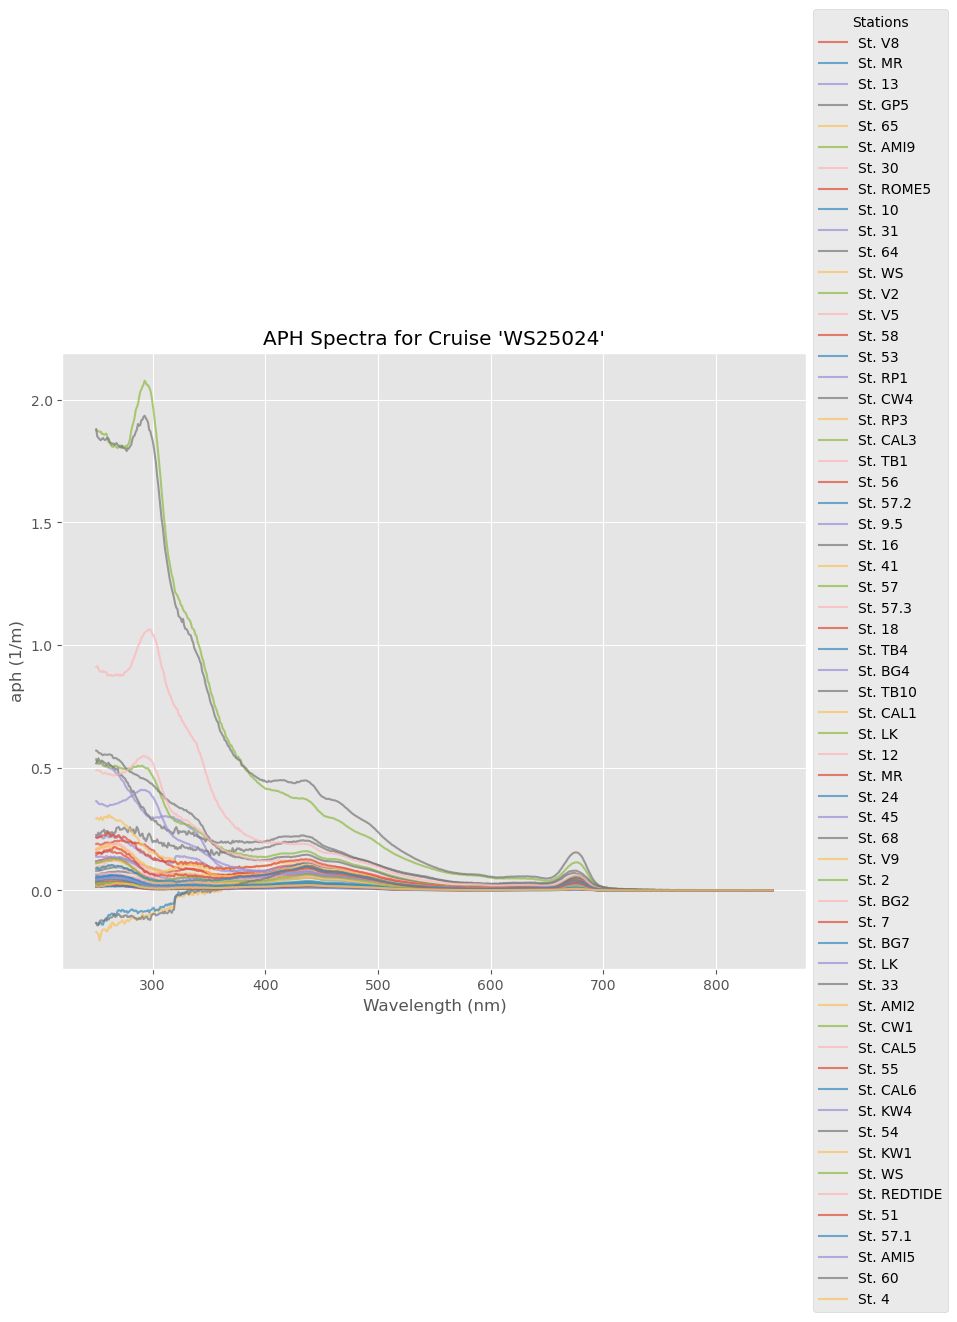

In [3]:
# --- Configuration ---
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
PARAMETER_TO_PLOT = 'aph'
TARGET_CRUISE = 'WS25024'
TARGET_STATION = 'ALL' # Set to 'ALL', None, or a specific station like 'WS'
# ---------------------

# --- 1. Find all .sb files ---
search_path = os.path.join(DECOMPRESSED_FOLDER, '**', '*.sb')
all_sb_files = glob.glob(search_path, recursive=True)

# --- List to hold data for the *next* cell ---
files_to_map = [] 
# ---------------------------------------------

files_to_process = []
station_labels = []

print(f"Found {len(all_sb_files)} total .sb files. Filtering based on headers...")

# --- 2. Filter files by reading metadata ---
for f_path in all_sb_files:
    try:
        sb_data = readSB(filename=f_path, no_warn=True)
        
        # --- Apply Filters ---
        if sb_data.headers.get('cruise') != TARGET_CRUISE:
            continue
            
        file_station = sb_data.headers.get('station', 'unknown')
        if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
            if file_station != TARGET_STATION:
                continue
                
        if 'wavelength' not in sb_data.data or PARAMETER_TO_PLOT not in sb_data.data:
            continue
            
        # --- If all checks pass, save file for plotting ---
        files_to_process.append(f_path)
        station_labels.append(file_station)
        
        # --- Extract and save coordinate data for mapping ---
        lat_str = sb_data.headers.get('north_latitude', None)
        lon_str = sb_data.headers.get('east_longitude', None)
        
        if lat_str and lon_str:
            try:
                lat = float(lat_str.replace('[DEG]', ''))
                lon = float(lon_str.replace('[DEG]', ''))
                # Add this file's info to our map list
                files_to_map.append({
                    'station': file_station,
                    'lat': lat,
                    'lon': lon,
                    'file': os.path.basename(f_path)
                })
            except (ValueError, TypeError):
                print(f"  -> Warning: Could not parse coordinates for {os.path.basename(f_path)}. Will not be mapped.")
        
    except Exception as e:
        print(f"  -> Warning: Skipped {os.path.basename(f_path)} due to read error: {e}")

# --- 3. Plot the filtered files ---
if not files_to_process:
    print(f"\nNo files matched your filter criteria. Nothing to plot.")
    # ... (rest of error printing) ...
else:
    print(f"\nFound {len(files_to_process)} files to plot. Reading and plotting...")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for f_path, station_label in zip(files_to_process, station_labels):
        # ... (rest of plotting code is identical) ...
        try:
            sb_data = readSB(filename=f_path, no_warn=True)
            df = pd.DataFrame(sb_data.data)
            df['wavelength'] = pd.to_numeric(df['wavelength'], errors='coerce')
            df[PARAMETER_TO_PLOT] = pd.to_numeric(df[PARAMETER_TO_PLOT], errors='coerce')
            df_clean = df.dropna(subset=['wavelength', PARAMETER_TO_PLOT])
            df_sorted = df_clean.sort_values(by='wavelength')
            ax.plot(df_sorted['wavelength'], df_sorted[PARAMETER_TO_PLOT], 
                    label=f"St. {station_label}", 
                    alpha=0.7)
        except Exception as e:
            print(f"  -> ERROR plotting {os.path.basename(f_path)}: {e}")

    # --- 4. Finalize Plot ---
    plot_title = f"{PARAMETER_TO_PLOT.upper()} Spectra for Cruise '{TARGET_CRUISE}'"
    if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
        plot_title += f" (Station: {TARGET_STATION})"
    
    ax.set_title(plot_title)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(f"{PARAMETER_TO_PLOT} (1/m)")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Stations")
    ax.grid(True)
    plt.show()

### Show the location of the sampling station

In [4]:
print("--- Generating Map ---")

# Check if the 'files_to_map' list was created by the previous cell
if 'files_to_map' not in locals() or not files_to_map:
    print("ERROR: 'files_to_map' list not found or is empty.")
    print("Please (re)run the previous cell (Cell 3) to filter and collect data first.")
else:
    print(f"Found {len(files_to_map)} stations to map.")
    
    # Calculate the center of the map
    lats = [item['lat'] for item in files_to_map]
    lons = [item['lon'] for item in files_to_map]
    avg_lat = sum(lats) / len(lats)
    avg_lon = sum(lons) / len(lons)

    # Create the map, centered on the average location
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)
    
    # Create a cluster group to hold the markers
    marker_cluster = MarkerCluster().add_to(m)

    # Add a marker for each file found
    for item in files_to_map:
        
        # Create popup message
        popup_html = f"""
        <b>Station:</b> {item['station']}<br>
        <b>File:</b> {item['file']}<br>
        <b>Coords:</b> {item['lat']}, {item['lon']}
        """

        # Add a marker to the *cluster*
        folium.Marker(
            [item['lat'], item['lon']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Station {item['station']}"
        ).add_to(marker_cluster)

    # Display the map
    print("Displaying map with all filtered stations...")
    display(m)

--- Generating Map ---
Found 61 stations to map.
Displaying map with all filtered stations...


### Load SFER_data.csv and Create Final Table

In [5]:
# --- Configuration ---
# Folder with decompressed files (from Cell 2)
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
SFER_FILE = 'SFER_data.csv'

# Output filename for the TSV
OUTPUT_FILENAME = 'merged_seabass_sfer_data.tsv'

# 1. Parameter to filter by and extract
PARAMETER_TO_EXTRACT = 'ag'
TARGET_WAVELENGTH = 443

# 2. Cruise ID to filter by
#    Set to 'ALL' to match ALL cruises found in the files
TARGET_CRUISE = 'ALL'

# 3. Station ID to filter by
#    Set to 'ALL' or None to get all stations from the cruise.
TARGET_STATION = 'ALL' 
# --- End Configuration ---

# --- 1. Find all .sb files ---
search_path = os.path.join(DECOMPRESSED_FOLDER, '**', '*.sb')
all_sb_files = glob.glob(search_path, recursive=True)

# This list will hold the extracted data from each file
extracted_data_list = []

print(f"Found {len(all_sb_files)} total .sb files. Filtering and extracting...")

# --- 2. Filter files and extract data ---
for f_path in all_sb_files:
    try:
        sb_data = readSB(filename=f_path, no_warn=True)
        
        # Get headers safely
        file_cruise = sb_data.headers.get('cruise', 'unknown')
        file_station = sb_data.headers.get('station', 'unknown')
        
        # --- Apply Filters ---
        
        # Filter 1: Check Cruise ID (Modified to support 'ALL')
        if TARGET_CRUISE != 'ALL':
            if file_cruise != TARGET_CRUISE:
                continue
            
        # Filter 2: Check Station ID
        if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
            if file_station != TARGET_STATION:
                continue
                
        # Filter 3: Check fields
        if 'wavelength' not in sb_data.data or PARAMETER_TO_EXTRACT not in sb_data.data:
            continue
            
        # --- If all checks pass, extract the data ---
        
        # A) Extract metadata
        lat_str = sb_data.headers.get('north_latitude', None)
        lon_str = sb_data.headers.get('east_longitude', None)
        dt_list = sb_data.fd_datetime()
        
        # B) Parse metadata
        dt_object = dt_list[0] if dt_list else None
        
        try:
            lat_float = float(lat_str.replace('[DEG]', '')) if lat_str else np.nan
            lon_float = float(lon_str.replace('[DEG]', '')) if lon_str else np.nan
        except ValueError:
            lat_float = np.nan
            lon_float = np.nan
        
        # C) Extract target value (e.g., ag at 443nm)
        df = pd.DataFrame(sb_data.data)
        df['wavelength'] = pd.to_numeric(df['wavelength'], errors='coerce')
        df[PARAMETER_TO_EXTRACT] = pd.to_numeric(df[PARAMETER_TO_EXTRACT], errors='coerce')
        
        target_row = df[df['wavelength'] == TARGET_WAVELENGTH]
        
        param_value = np.nan
        if not target_row.empty:
            param_value = target_row[PARAMETER_TO_EXTRACT].values[0]
            
        # D) Add all data to our list (Modified as requested)
        extracted_data_list.append({
            'cruise_id': file_cruise,
            'station_id': file_station,
            'latitude': lat_float,
            'longitude': lon_float,
            'datetime_sb': dt_object,
            f'{PARAMETER_TO_EXTRACT}_{TARGET_WAVELENGTH}': param_value,
            'seabass_filename': os.path.basename(f_path)
        })
        
    except Exception as e:
        print(f"  -> Warning: Skipped {os.path.basename(f_path)} due to read error: {e}")

# --- 3. Create the main DataFrame from the .sb files ---
if not extracted_data_list:
    print("\nNo files matched the filter criteria. No data to merge.")
else:
    sb_df = pd.DataFrame(extracted_data_list)
    print(f"\nExtracted data from {len(sb_df)} matching .sb files.")
    
    # --- 4. Load and Merge with SFER_data.csv ---
    if not os.path.exists(SFER_FILE):
        print(f"ERROR: File not found: {SFER_FILE}")
    else:
        try:
            print(f"Loading {SFER_FILE} for merging...")
            sfer_df = pd.read_csv(SFER_FILE, low_memory=False)

            # --- Keep only 'Surface' depth_class ---
            if 'depth_class' in sfer_df.columns:
                initial_count = len(sfer_df)
                sfer_df = sfer_df[sfer_df['depth_class'] == 'Surface']
                final_count = len(sfer_df)
                print(f"Filtered SFER data: Kept {final_count} 'Surface' rows (dropped {initial_count - final_count} non-surface rows).")
            else:
                print("Warning: 'depth_class' column not found in SFER_data.csv. Skipping surface filter.")
            # -------------------------------------------------------

            # Prepare SFER_data for merging
            # Rename datetime to datetime_sfer to avoid collision and confusion
            if 'datetime' in sfer_df.columns:
                sfer_df.rename(columns={'datetime': 'datetime_sfer'}, inplace=True)
            
            # Ensure merge keys are strings/objects for consistent matching
            sfer_df['station'] = sfer_df['station'].astype(str)
            sfer_df['cruise_id'] = sfer_df['cruise_id'].astype(str)

            # Prepare sb_df for merging
            sb_df['station_id'] = sb_df['station_id'].astype(str)
            sb_df['cruise_id'] = sb_df['cruise_id'].astype(str)
            
            print("Merging data (by cruise_id and station_id)...")
            # Merge left on cruise_id and station_id
            merged_df = pd.merge(
                sb_df,
                sfer_df,
                left_on=['cruise_id', 'station_id'],
                right_on=['cruise_id', 'station'],
                how='left'
            )

            # Define the final column order
            param_col_name = f'{PARAMETER_TO_EXTRACT}_{TARGET_WAVELENGTH}'
            final_column_order = [
                'keyfield',
                'cruise_id',
                'station_id',
                'latitude',
                'longitude',
                'datetime_sfer',
                'datetime_sb',
                param_col_name,
                'seabass_filename'
            ]
            
            # Select and reorder columns (filtering for ones that actually exist)
            # We use a list comprehension to robustly handle missing columns if any match fails completely
            cols_to_keep = [col for col in final_column_order if col in merged_df.columns]
            
            # If cols missing, warn user
            missing_cols = [col for col in final_column_order if col not in merged_df.columns]
            if missing_cols:
                print(f"Warning: The following requested columns were not found after merge: {missing_cols}")
            
            final_table = merged_df[cols_to_keep]

            # 6. Display the final table
            print("\n--- Final Merged Table (Sample) ---")
            print(final_table.head().to_markdown(index=False))

            # --- Identify and list unique unmatched Cruise/Station IDs ---
            unmatched_df = final_table[final_table['keyfield'].isna()]
            
            if not unmatched_df.empty:
                print("\n--- Unmatched Files Report ---")
                print(f"Found {len(unmatched_df)} rows where .sb data did not match SFER_data.csv.")
                
                # Get unique pairs of cruise_id and station_id
                unique_unmatched = unmatched_df[['cruise_id', 'station_id']].drop_duplicates()
                
                print(f"Unique Cruise ID / Station ID pairs that were not found in {SFER_FILE}:")
                print(unique_unmatched.to_markdown(index=False))
            else:
                print("\nAll .sb files were successfully matched to SFER_data.csv.")
            # ------------------------------------------------------------------
            
            # 7. Save to .tsv file
            print(f"\nSaving table to '{OUTPUT_FILENAME}'...")
            final_table.to_csv(OUTPUT_FILENAME, sep='\t', index=False)
            print("Save complete.")

        except Exception as e:
            print(f"An error occurred during the merge process: {e}")

Found 5381 total .sb files. Filtering and extracting...

Extracted data from 2319 matching .sb files.
Loading SFER_data.csv for merging...
Filtered SFER data: Kept 6374 'Surface' rows (dropped 2926 non-surface rows).
Merging data (by cruise_id and station_id)...

--- Final Merged Table (Sample) ---
| keyfield                        | cruise_id   | station_id   |   latitude |   longitude | datetime_sfer       | datetime_sb         |   ag_443 | seabass_filename                               |
|:--------------------------------|:------------|:-------------|-----------:|------------:|:--------------------|:--------------------|---------:|:-----------------------------------------------|
| 20161105_1302_WS16130_55_1_Surf | WS16130     | 55           |    25.3502 |    -81.1933 | 2016-05-11 13:02:00 | 2016-05-11 13:02:00 | 0.627222 | SFMBON_WS16130_ag_55_1m_102_201605111302_R3.sb |
| 20161205_1617_WS16130_55_1_Surf | WS16130     | 55           |    25.3502 |    -81.1933 | 2016-05-12 16:17:00 

### Check for unmatched .sb files

In [6]:
# --- Check for Unmatched .sb Files ---

if 'final_table' not in locals():
    print("ERROR: 'final_table' variable not found.")
    print("Please run the previous cell (Merge Data) first.")
else:
    # Filter for rows where 'keyfield' is NaN (missing)
    # This happens when the left merge (from .sb data) finds no match in the right df (SFER data)
    unmatched_df = final_table[final_table['keyfield'].isna()]
    num_unmatched = len(unmatched_df)

    if num_unmatched > 0:
        print(f"\n⚠️ WARNING: Found {num_unmatched} .sb files that did NOT match SFER_data.csv.")
        print("The following files have valid SeaBASS data but no corresponding metadata in your CSV:")
        print("-" * 80)
        
        # Select columns to help identify the culprit
        cols_to_show = ['cruise_id', 'station_id', 'seabass_filename']
        
        # Print the table
        print(unmatched_df[cols_to_show].to_markdown(index=False))
        
        print("-" * 80)
        print("Troubleshooting Tips:")
        print("1. Check Station IDs: Does '.sb' station 'WS' match 'WS' in the CSV? (e.g., 'WS' vs 'ws' vs 'WS1')")
        print("2. Check Cruise IDs: Are they identical strings?")
        print("3. Missing Data: These stations might simply not exist in the SFER_data.csv file.")
    else:
        print(f"\n✅ SUCCESS: All {len(final_table)} .sb files were successfully matched with SFER_data.csv!")


⚠️ WARNING: Found 337 .sb files that did NOT match SFER_data.csv.
The following files have valid SeaBASS data but no corresponding metadata in your CSV:
--------------------------------------------------------------------------------
| cruise_id   | station_id   | seabass_filename                                     |
|:------------|:-------------|:-----------------------------------------------------|
| WS16130     | LK           | SFMBON_WS16130_ag_LK_1m_018_201605101310_R3.sb       |
| WS16130     | LK           | SFMBON_WS16130_ag_LK_29m_024_201605101310_R3.sb      |
| WS21151     | LK           | SFMBON_WS21151_ag_LK_1m_033_202106010328_R3.sb       |
| WS21151     | LK           | SFMBON_WS21151_ag_LK_35m_037_202106010328_R3.sb      |
| WS17086     | LK           | SFMBON_WS17086_ag_LK_1m_032_201703281406_R3.sb       |
| WS17086     | LK           | SFMBON_WS17086_ag_LK_36m_036_201703281406_R3.sb      |
| WS17086     | 57.0         | SFMBON_WS17086_ag_57.0_1m_080_201703291706_R3.

### Correct cruise and station ID's of unmatched .sb files and remerge records with SFER_data

In [ ]:
# --- Correction & Remerging Cell ---

# --- FILE CORRECTIONS:
# Changed original filename 'SFMBON_WS21093_ap_49_1m_105_202104050623_R1.sb' to station 45 because the station ID was incorrect in the .sb file.

# 1. Define Correction Maps
#    Add any unmatched IDs you found here.
#    Format: { 'ID_in_SeaBASS_file' : 'ID_in_SFER_CSV' }
station_corrections = {
    'LK': '21LK',       # Fixes station LK -> 21LK
    '57.0': '57',  
    'kw2': 'KW2',
    'cal1': 'CAL1',
    'cal3': 'CAL3',
    'cal5': 'CAL5',
    'Cal1': 'CAL1',
    'Cal3': 'CAL3',
    'Cal5': 'CAL5'
}

cruise_corrections = {
    'H23138': 'HG23138', 
    'WS20278': 'WS20279',
    'WS21277': 'WS21278',
    'H23314': 'HG23314'
}

# Check if 'sb_df' exists from the previous cell
if 'sb_df' not in locals():
    print("ERROR: 'sb_df' dataframe not found. Please run the extraction cell first.")
else:
    print("Applying ID corrections to SeaBASS data...")

    # 2. Apply Corrections to sb_df
    # .replace() looks for the keys in the dict and swaps them with values
    sb_df['station_id'] = sb_df['station_id'].replace(station_corrections)
    sb_df['cruise_id'] = sb_df['cruise_id'].replace(cruise_corrections)

    # 3. Re-Merge with SFER Data
    #    We use the already loaded 'sfer_df' if available, or reload it.
    if 'sfer_df' not in locals():
        if os.path.exists(SFER_FILE):
            sfer_df = pd.read_csv(SFER_FILE, low_memory=False)
            if 'datetime' in sfer_df.columns:
                sfer_df.rename(columns={'datetime': 'datetime_sfer'}, inplace=True)
            sfer_df['station'] = sfer_df['station'].astype(str)
            sfer_df['cruise_id'] = sfer_df['cruise_id'].astype(str)
        else:
            print(f"ERROR: {SFER_FILE} not found.")
            sfer_df = pd.DataFrame()

    if not sfer_df.empty:
        print("Re-merging data with corrected IDs...")
        
        # Perform the merge again
        final_merged_df = pd.merge(
            sb_df,
            sfer_df,
            left_on=['cruise_id', 'station_id'],
            right_on=['cruise_id', 'station'],
            how='left'
        )

        # 4. Select and Order Columns
        #    Define the columns we want in the final output
        target_columns = [
            'keyfield',
            'cruise_id',
            'station_id',
            'latitude',
            'longitude',
            'datetime_sfer',
            'datetime_sb',
            f'{PARAMETER_TO_EXTRACT}_{TARGET_WAVELENGTH}', # e.g. ag_443
            'seabass_filename'
        ]
        
        # Filter for columns that actually exist to avoid errors
        existing_cols = [c for c in target_columns if c in final_merged_df.columns]
        final_table_corrected = final_merged_df[existing_cols]

        # 5. Check for mismatches and Exclude them
        remaining_unmatched = final_table_corrected[final_table_corrected['keyfield'].isna()]
        
        if not remaining_unmatched.empty:
            print(f"\n⚠️ Found {len(remaining_unmatched)} unmatched records.")
            print("Unique IDs missing from SFER_data (These rows will be EXCLUDED from the final file):")
            print(remaining_unmatched[['cruise_id', 'station_id']].drop_duplicates().to_markdown(index=False))
            
            # --- EXCLUDE ROWS WITH EMPTY KEYFIELD ---
            print(f"Removing {len(remaining_unmatched)} rows with empty keyfield...")
            final_table_corrected = final_table_corrected.dropna(subset=['keyfield'])
        else:
            print("\n✅ SUCCESS: All records matched successfully!")

        # 6. Sort final table by datetime_sfer
        if 'datetime_sfer' in final_table_corrected.columns:
            final_table_corrected = final_table_corrected.sort_values(by='datetime_sfer')

        # 7. Display Results (Cleaned)
        print("\n--- Corrected Final Table (First 5 Rows) ---")
        print(final_table_corrected.head().to_markdown(index=False))

        # 8. Save the corrected file
        final_table_corrected.to_csv(OUTPUT_FILENAME, sep='\t', index=False)
        print(f"\nSaved cleaned table to: {OUTPUT_FILENAME}")

Applying ID corrections to SeaBASS data...
Re-merging data with corrected IDs...

⚠️ Found 16 unmatched records.
Unique IDs missing from SFER_data (These rows will be EXCLUDED from the final file):
| cruise_id   | station_id   |
|:------------|:-------------|
| WS25024     | REDTIDE      |
| WS21093     | 49           |
| WS19210     | 9B           |
| WS19119     | CBH          |
| WS19119     | NBH          |
| WS18351     | 9B           |
| FK1508      | 21LK         |
| FK1508      | WS           |
| FK1508      | MR           |
| WS18285     | Z04-068      |
Removing 16 rows with empty keyfield...

--- Corrected Final Table (First 5 Rows) ---
| keyfield                        | cruise_id   | station_id   |   latitude |   longitude | datetime_sfer       | datetime_sb         |   ag_443 | seabass_filename                               |
|:--------------------------------|:------------|:-------------|-----------:|------------:|:--------------------|:--------------------|---------:|:-